In [1]:
import xarray as xr
from dask.distributed import Client
client = Client('tcp://10.0.0.241:8786')

In [3]:
client

Client Scheduler: tcp://10.0.0.241:8786 Dashboard: http://10.0.0.241:8787/status,Cluster Workers: 4 Cores: 64 Memory: 266.38 GB


## Hydroloop run

In [12]:
import os
import sys
sys.path.append(r'/efs/CWA/scripts_aridity')
import pandas as pd
import time

from WAsheets import calculate_flux as cf
from WAsheets import hydroloop as hl

In [20]:
wp_folder=r"/efs/CWA/netcdf_files_11_15_" #folder with nc files from water balance model
BASIN={
       'name': 'AFR',
       'hydroyear':'A-DEC', #Water year end month
       'chunksize':[1, 1000, 1000],
       'unit_conversion':1e6, #1e3 for input data in MCM, 1e6 for input data in km3
       'output_folder':r"/efs/CWA/hydroloop_results_11_15_/",
       'gis_data':{
               'basin_mask': r'/efs/CWA/static_datasets/basin_mask/AFR_basinmask_1km.tif',
               'subbasin_mask':{
                       1: r"/efs/CWA/static_datasets/basin_mask/AFR_basinmask_1km.tif"                       
                       },
               'dem':r"/efs/CWA/static_datasets/DEM/DEM_HydroShed_1km_AFR.tif",
               'aeisw':r"/efs/CWA/static_datasets/AEISW/AFR_gmia_v5_aei_pct_1km.tif", #area equipped with surface water irrigation percentage
               'population':r"/efs/CWA/static_datasets/Population/AFR_PPP_2015_adj_v2_1km.tif",
               'wpl':r"/efs/CWA/static_datasets/WPL/WPL_Max1.tif",
               'environ_water_req': r"/efs/CWA/static_datasets/EWR/EWR.tif"
               },
       'data_cube':{
           'monthly':{
               'p':os.path.join(wp_folder,
                                          'AFR_P_CHIRPS.nc'),
                'etref':os.path.join(wp_folder,
                                          'AFR_ETref_WA.nc'),
               'et':os.path.join(wp_folder,
                                          'AFR_ETa_SSEBop.nc'),
               'i':os.path.join(wp_folder,
                                          'i_monthly.nc'),
               't':None,
               'e':None,
               'nrd':os.path.join(wp_folder,
                                          'nRD_monthly.nc'),
               'etincr':os.path.join(wp_folder,
                                          'etincr_monthly.nc'),
               'etrain':os.path.join(wp_folder,
                                          'etrain_monthly.nc'),
               'lai':os.path.join(wp_folder,
                                          'AFR_LAI_MOD15.nc'),
              'ndm':os.path.join(wp_folder,
                                          'AFR_NDM_ProbaV.nc'),
             'sro':os.path.join(wp_folder,
                                         'sro_monthly.nc'),
             'sroincr':os.path.join(wp_folder,
                                          'd_sro_monthly.nc'),
             'perc':os.path.join(wp_folder,
                                          'perco_monthly.nc'),
             'percincr':os.path.join(wp_folder,
                                          'd_perco_monthly.nc'),
             'bf':os.path.join(wp_folder,
                                          'bf_monthly.nc'),
            'supply':os.path.join(wp_folder,
                                          'supply_monthly.nc')
               },
           'yearly':{
                'lu':os.path.join(wp_folder,
                                          'AFR_LU_WA.nc'),
                   }      
                     },
        'ts_data':{
                'q_in_sw':{
                        'basin':None,
                        1:None, #unit MCM
                        2:None,
                        },
                'q_in_gw':{
                        'basin':None,
                        1:None, #unit MCM
                        2:None,
                        },
                'q_in_desal':{
                        'basin':r'/efs/CWA/flow_data/11_15/static_datasets/AFR_desal.csv',
                        1:r'/efs/CWA/flow_data/11_15/static_datasets/AFR_desal.csv', #unit MCM
                        2:None,
                        },
                'q_outflow':{ #river flow
                        'basin':r'/efs/CWA/flow_data/11_15/outflows.csv',
                        1:None,
                        2:None
                        },
                'q_out_sw':{ #interbasin transfer
                        'basin':None,
                        1:None,
                        2:None,
                        },
                'q_out_gw':{ #interbasin transfer
                        'basin':None,
                        1:None,
                        2:None,
                        },
                'dS_sw':{
                        'basin':None,
                        1:None, #unit MCM
                        2:None,
                        },
                                
                },
        'params':{
            'crops':{#lu_code: [r'seasons_dates.csv','Crop_type']
                    35.0: [r'/efs/Cimanuk/static_datasets/growing seasons/rice_rain_java.txt','N/A'],
                    54.0: [r'/efs/Cimanuk/static_datasets/growing seasons/rice_irrigated_java.txt','N/A'],    
                    52.0: [r'/efs/Cimanuk/static_datasets/growing seasons/palm_perennial.txt','N/A'],
                    33.0: [r'/efs/Cimanuk/static_datasets/growing seasons/palm_perennial.txt','N/A']             
                    },
            'dico_in':{1:[0]},
            'dico_out':{1:[]},
            'residential_sw_supply_fraction':0.6,
            'wcpc':110, #Water consumption per capita per day in [liter/person/day]
            'wcpc_min':100, #minimum demand
            'fraction_xs':[4,25,4,25]
        }
        
       }
            

In [21]:
# Run from here

BASIN['data_cube']['monthly']['supply'] = os.path.join(wp_folder,'return.nc')
BASIN['data_cube']['monthly']['supply_sw'] = os.path.join(wp_folder,'total_sw_supply.nc')
BASIN['data_cube']['monthly']['supply_gw'] = os.path.join(wp_folder,'total_gw_supply.nc')
BASIN['data_cube']['monthly']['return_sw_from_sw'] = os.path.join(wp_folder,'total_return_sw_from_sw.nc')
BASIN['data_cube']['monthly']['return_gw_from_gw'] = os.path.join(wp_folder,'total_return_gw_from_gw.nc')
BASIN['data_cube']['monthly']['demand'] = os.path.join(wp_folder,'total_demand.nc')
BASIN['data_cube']['monthly']['return_sw'] = os.path.join(wp_folder,'return_sw.nc')
BASIN['data_cube']['monthly']['return_gw'] = os.path.join(wp_folder,'return_gw.nc')
BASIN['data_cube']['monthly']['supply'] = os.path.join(wp_folder,'total_supply.nc')
BASIN['data_cube']['monthly']['t'] = os.path.join(wp_folder,'transpiration.nc')
BASIN['data_cube']['monthly']['e'] = os.path.join(wp_folder,'evaporation.nc')
BASIN['data_cube']['monthly']['lu'] = os.path.join(wp_folder,'AFR_LU_WA_resampled_monthly.nc')
BASIN['data_cube']['monthly']['fraction'] = os.path.join(wp_folder,'fractions.nc')

BASIN['data_cube']['yearly']['supply'] = os.path.join(wp_folder,'return_yearly.nc')
BASIN['data_cube']['yearly']['supply_sw'] = os.path.join(wp_folder,'total_sw_supply_yearly.nc')
BASIN['data_cube']['yearly']['supply_gw'] = os.path.join(wp_folder,'total_gw_supply_yearly.nc')
BASIN['data_cube']['yearly']['return_sw_from_sw'] = os.path.join(wp_folder,'total_return_sw_from_sw_yearly.nc')
BASIN['data_cube']['yearly']['return_gw_from_gw'] = os.path.join(wp_folder,'total_return_gw_from_gw_yearly.nc')
BASIN['data_cube']['yearly']['demand'] = os.path.join(wp_folder,'total_demand_yearly.nc')
BASIN['data_cube']['yearly']['return_sw'] = os.path.join(wp_folder,'return_sw_yearly.nc')
BASIN['data_cube']['yearly']['return_gw'] = os.path.join(wp_folder,'return_gw_yearly.nc')
BASIN['data_cube']['yearly']['supply'] = os.path.join(wp_folder,'total_supply_yearly.nc')
BASIN['data_cube']['yearly']['t'] = os.path.join(wp_folder,'transpiration_yearly.nc')
BASIN['data_cube']['yearly']['e'] = os.path.join(wp_folder,'evaporation_yearly.nc')
BASIN['data_cube']['yearly']['lu'] = os.path.join(wp_folder,'AFR_LU_WA_resampled_yearly_yearly.nc')
BASIN['data_cube']['yearly']['fraction'] = os.path.join(wp_folder,'fractions_yearly.nc')

Save basin flux as /efs/CWA/hydroloop_results_11_15_/subbasin_1_sro.csv
Save basin flux as /efs/CWA/hydroloop_results_11_15_/subbasin_1_return_sw.csv
Save basin flux as /efs/CWA/hydroloop_results_11_15_/subbasin_1_bf.csv
Save basin flux as /efs/CWA/hydroloop_results_11_15_/subbasin_1_supply_sw.csv


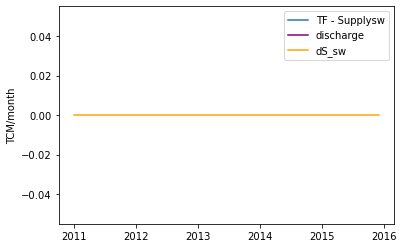

In [22]:
### Calculate subbasin-wide timeseries

for sb in BASIN['gis_data']['subbasin_mask']:
    subbasin={}
    for key in ['sro','return_sw','bf','supply_sw']:
        output=os.path.join(BASIN['output_folder'],
                            'subbasin_{0}_{1}.csv'.format(sb,key))
        df=cf.calc_flux_per_basin(BASIN['data_cube']['monthly'][key],
                                BASIN['gis_data']['subbasin_mask'][sb],
                                output=output)
        subbasin[key]=df        
    # read subbasin inflow
    if len(BASIN['params']['dico_in'][sb])==0: #no inflow
        inflow=None 
    else: #1 or more inflows
        for i in range(len(BASIN['params']['dico_in'][sb])):            
            if BASIN['params']['dico_in'][sb][i] == 0: #inflow from outside
                needed_params = ['q_in_desal','q_in_sw','q_in_gw'] #check only inflows
                t = 0
                for q_in in BASIN['ts_data'].keys():
                    if (q_in in needed_params) and (BASIN['ts_data'][q_in][sb] != None):       #check csv                 
                        df_inflow_ = pd.read_csv(BASIN['ts_data'][q_in][sb],
                                      sep=';',index_col=0)
                        
                        if t == 0:
                            df_inflow = df_inflow_
                        else:
                            df_inflow = df_inflow + df_inflow_
                        
                        t += 1
                        
                if t == 0:                                
                    print('Warning, missing inflow textfiles, proceeding without inflow textfiles')
                 
                         
            else: #inflow from upstream subbasin                  
                subbasin_in=BASIN['params']['dico_in'][sb][i]
                df_inflow=pd.read_csv(
                        BASIN['ts_data']['q_outflow'][subbasin_in],
                                      sep=';',index_col=0) 
                # df_inflow = pd.read_csv(BASIN['ts_data']['q_in_sw'][subbasin_in],
                #                       sep=';',index_col=0)                
                #assuming that outflow of upstream subbasin was calculated before
            if i == 0:
                inflow=df_inflow
            else:
                inflow=inflow+df_inflow    
    
    ## Interbasin transfer outflow
    if BASIN['ts_data']['q_out_sw'][sb] == None:
        q_out_sw=None
    else: 
        q_out_sw = pd.read_csv(
                        BASIN['ts_data']['q_out_sw'][sb],
                                      sep=';',index_col=0)

    # calculate sw discharge and dS from pixel-based model results
    output=os.path.join(BASIN['output_folder'],
                        'subbasin_{0}_{1}.csv'.format(sb,'{0}'))
    discharge,dS_sw=hl.calc_sw_from_wp(subbasin['sro'],
                                        subbasin['return_sw'],
                                        subbasin['bf'],
                                        subbasin['supply_sw'],
                                        inflow=inflow,
                                        q_out_sw = q_out_sw,
                                        output=output,
                                        outflow=True, #not endorheic basin
                                        plot=True
                                        )
    BASIN['ts_data']['q_outflow'][sb]=discharge
    BASIN['ts_data']['dS_sw'][sb]=dS_sw    
    inflow = None

In [23]:
#%% Calculate yearly and (intermediate) monthly sheet csvs
from WAsheets import sheet1
from WAsheets import sheet2
from WAsheets import sheet3
from WAsheets import sheet4
from WAsheets import sheet5
from WAsheets import sheet6

sheet1_yearly_csvs=sheet1.main(BASIN,unit_conversion=BASIN['unit_conversion'])

Save basin flux as /efs/CWA/hydroloop_results_11_15_/csv/timeseries/sheet1_basin_p_monthly.csv
Save LU flux as /efs/CWA/hydroloop_results_11_15_/csv/timeseries/sheet1_basin_etrain_monthly.csv
Save LU flux as /efs/CWA/hydroloop_results_11_15_/csv/timeseries/sheet1_basin_etincr_monthly.csv
Calculating sheet 1 dS
P: 1964.8562460497646, ET:1356.3607369271451,Qin: 0.111403398, Qout:389.631030272, dS:218.86447885061955
Calculating sheet 1 dS
P: 1557.2229346285076, ET:1264.722694049697,Qin: 0.100622424, Qout:340.40238489599994, dS:-47.90214431718949
Calculating sheet 1 dS
P: 1920.8010520435762, ET:1447.0747955321997,Qin: 0.111403398, Qout:300.26468659200003, dS:173.46156991937647
Calculating sheet 1 dS
P: 1615.6904989451755, ET:1331.4861874439628,Qin: 0.10780974, Qout:220.12274688, dS:64.08156462121272
Calculating sheet 1 dS
P: 1413.9621535540498, ET:1452.4458398234253,Qin: 0.111403398, Qout:186.521284096, dS:-225.00497036537553
Calculating sheet 1 dS
P: 1331.559899205677, ET:1319.18149115417

In [24]:
from WAsheets import print_sheet as ps

if BASIN['unit_conversion'] == 1e6:
    str_unit='km3/year'
elif BASIN['unit_conversion']==1e3:
    str_unit='MCM/year'
    
for sheet1_csv in sheet1_yearly_csvs:
    period=os.path.basename(sheet1_csv).split('.')[0].split('_')[-1]
    output=sheet1_csv.replace('.csv','.pdf')
    ps.print_sheet1(BASIN['name'],period=period,
                    output=output,units=str_unit,data=sheet1_csv)


In [25]:
# end = time.time()
# total_time = end - start
# print ('total time :',total_time)

In [26]:
import glob
import os
from WAsheets import print_sheet_cwa as ps
import shutil

# str_unit='km3/year'

out_folder = BASIN['output_folder']

directory_path = os.path.join(out_folder,r'csv/sheet1/yearly_cwa/')
old_path = os.path.join(out_folder,r'csv/sheet1/yearly/')

try :
    shutil.copytree(old_path, directory_path)
except : 
    pass

csv_files = glob.glob(os.path.join(directory_path, '*.csv'))
sheet1_yearly_csvs = [file_path for file_path in csv_files]

basin = 'Africa'


for sheet1_csv in sheet1_yearly_csvs:
    period=os.path.basename(sheet1_csv).split('.')[0].split('_')[-1]
    output=sheet1_csv.replace('.csv','.pdf')
    ps.print_sheet1(basin,period=period,
                    output=output,units=str_unit,data=sheet1_csv)